# Vehicle Fuel Consumption Forecast

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')

In [5]:
column_name = ["MPG", "Cylinders", "Displacement","Horsepower","Weight","Acceleration","Model Year", "Origin"]
data = pd.read_csv("auto-mpg.data", names = column_name, na_values = "?", comment = "\t",sep = " ", skipinitialspace = True)

data = data.rename(columns = {"MPG":"target"})

print(data.head())

   target  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  


target          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


<AxesSubplot:xlabel='Horsepower', ylabel='Density'>

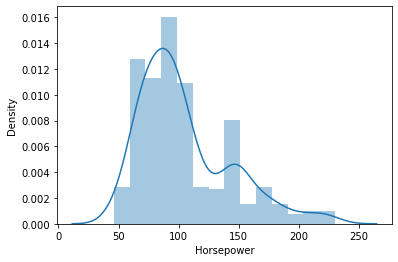

In [7]:
describe = data.describe()
#missing values
data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())
print(data.isna().sum())
sns.distplot(data.Horsepower)

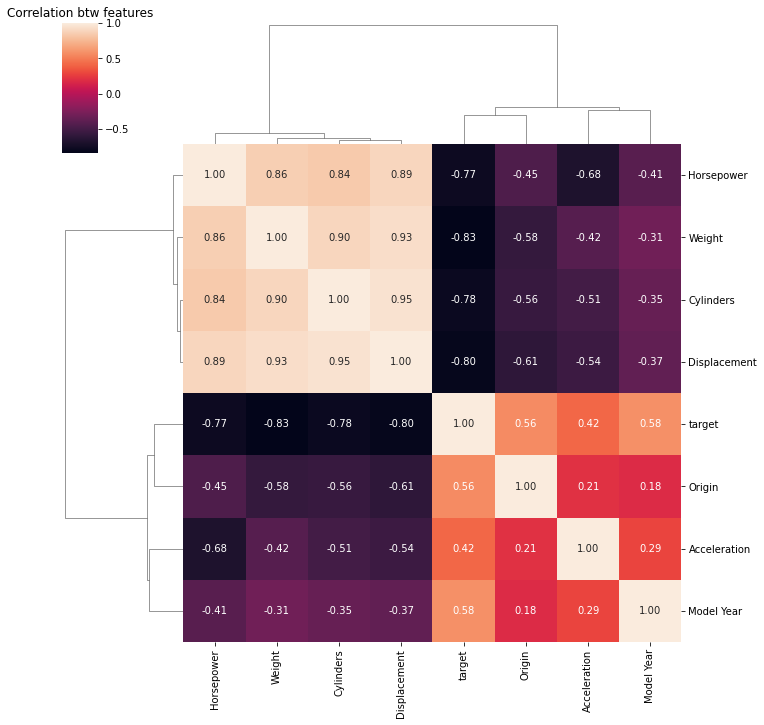

In [8]:
#Exploratory Data Analysis
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation btw features")
plt.show()

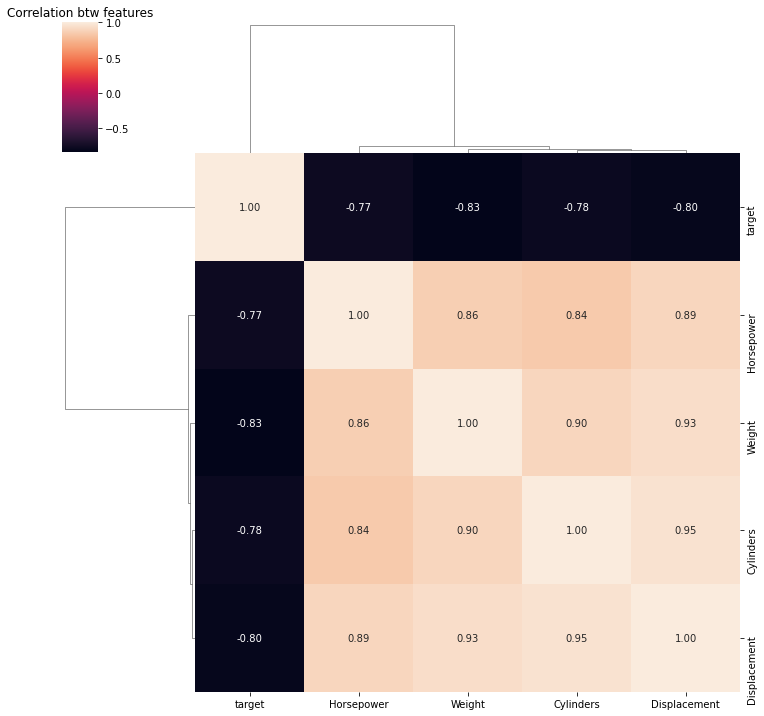

In [9]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"])>threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation btw features")
plt.show()

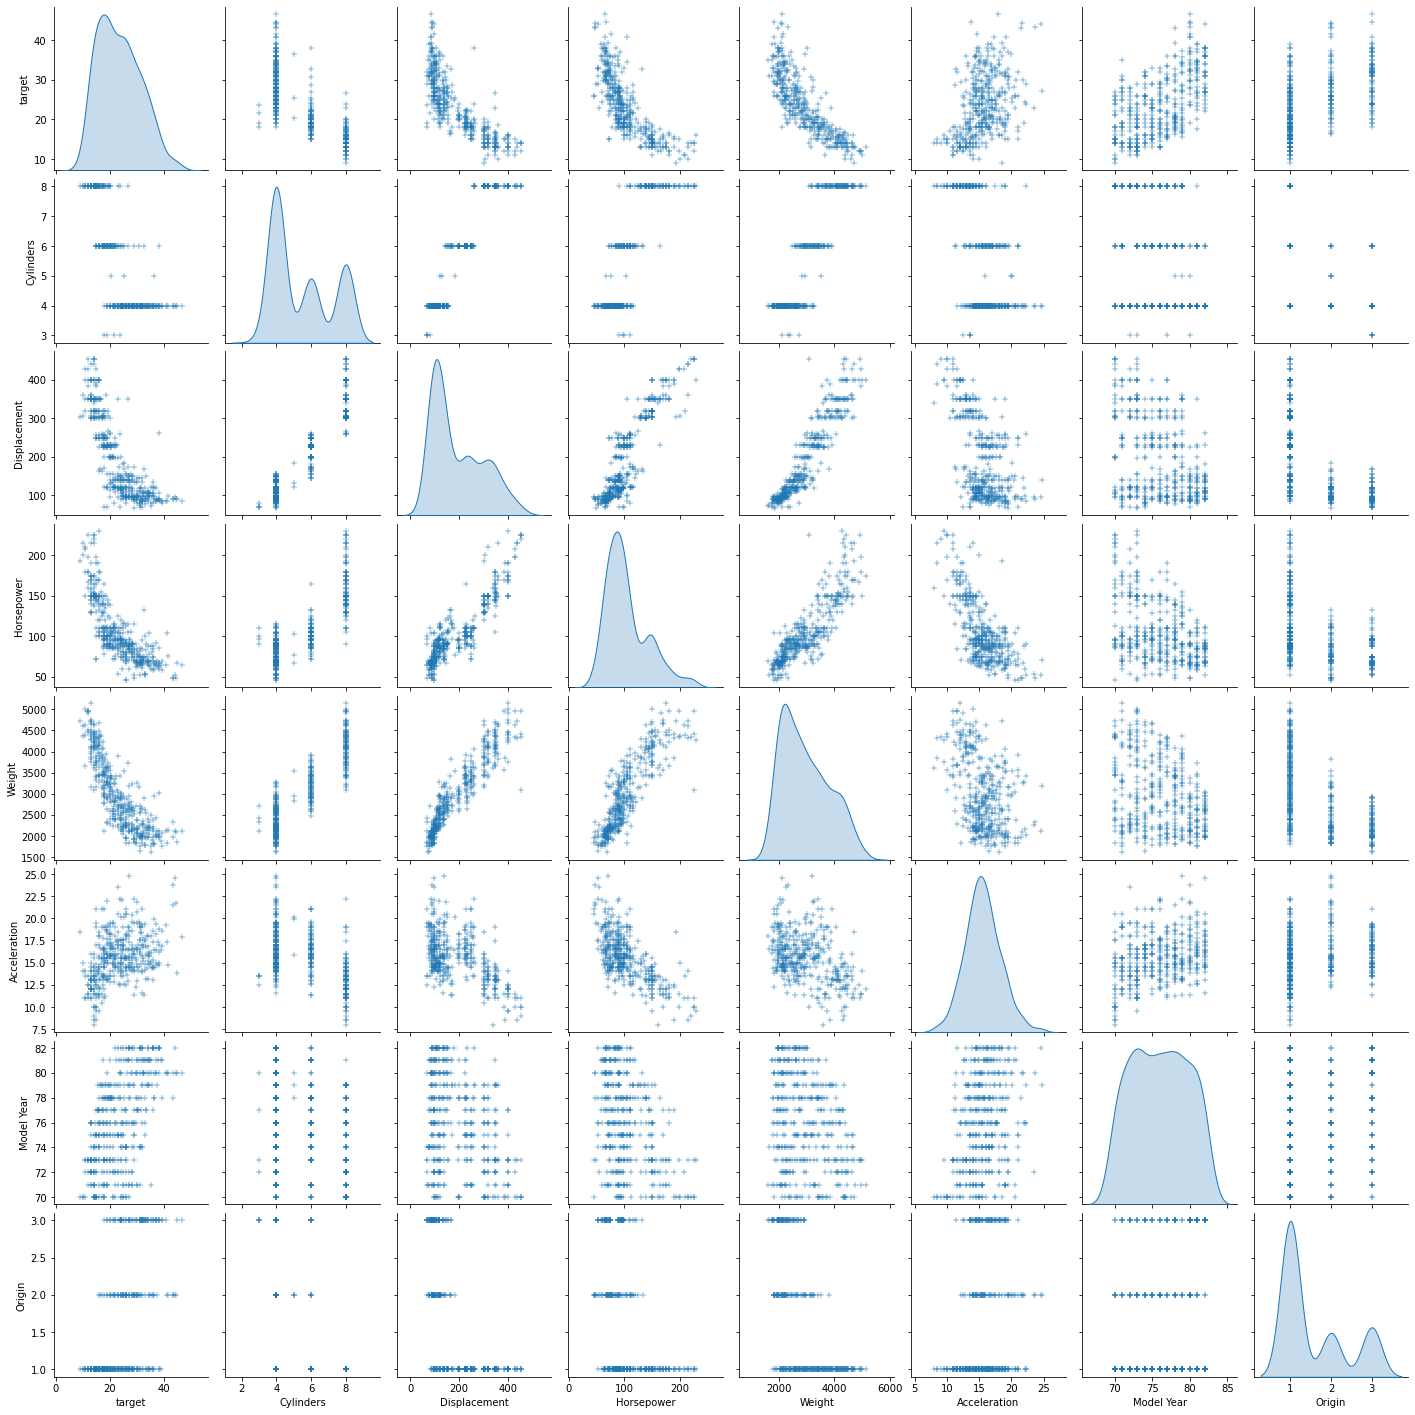

In [10]:
sns.pairplot(data, diag_kind = "kde", markers = "+")
plt.show()

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64


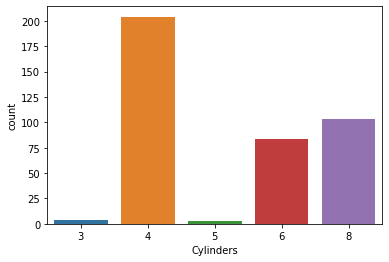

In [11]:
plt.figure()
sns.countplot(data["Cylinders"])
print(data["Cylinders"].value_counts())

1    249
3     79
2     70
Name: Origin, dtype: int64


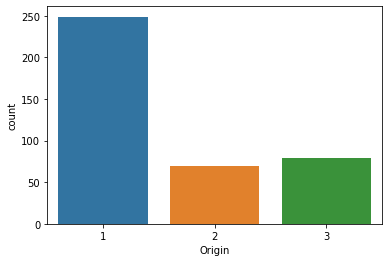

In [12]:
plt.figure()
sns.countplot(data["Origin"])
print(data["Origin"].value_counts())

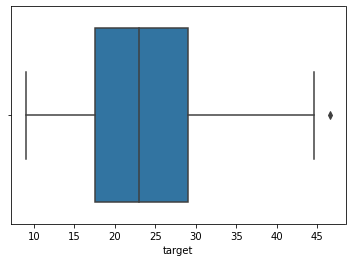

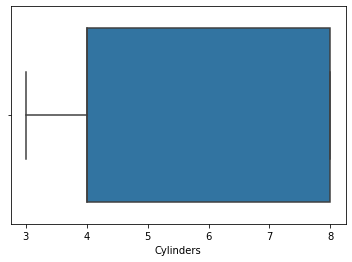

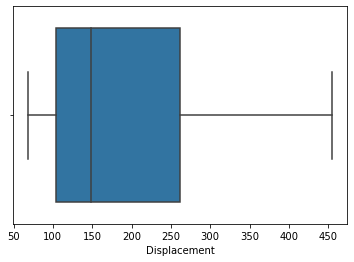

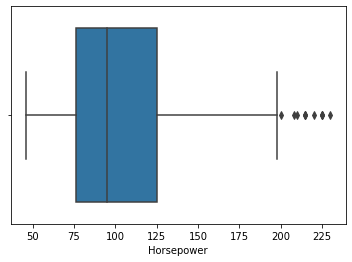

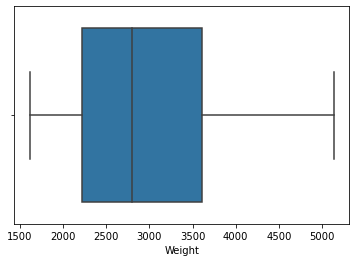

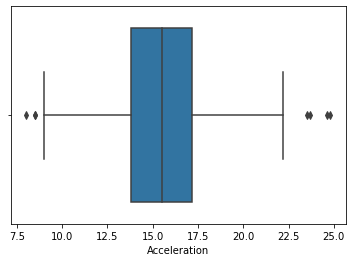

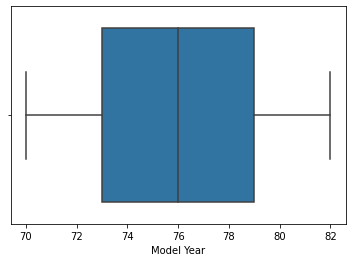

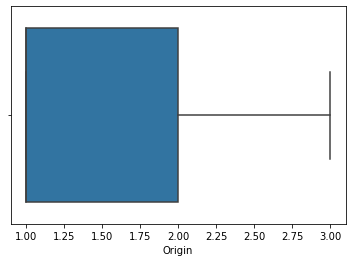

In [13]:
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "v")

In [14]:
#Outlier (HP & Acceleration)
thr = 2
horsepower_desc = describe["Horsepower"]
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp
filter_hp_bottom = bottom_limit_hp < data["Horsepower"]
filter_hp_top = data["Horsepower"] < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]

acceleration_desc = describe["Acceleration"]
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc # q3 - q1
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc
filter_acc_bottom = bottom_limit_acc < data["Acceleration"]
filter_acc_top= data["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc]

mu: 23.55, sigma = 7.7342235735537335


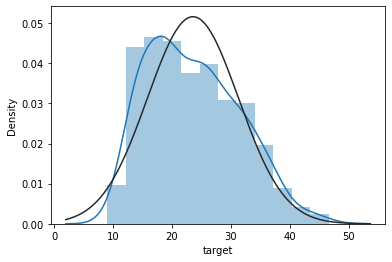

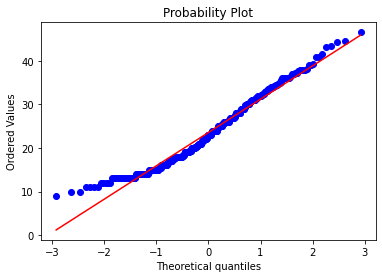

mu: 3.150194394612899, sigma = 0.32111064266913925


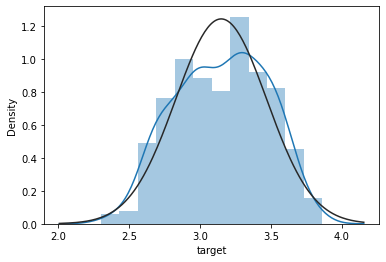

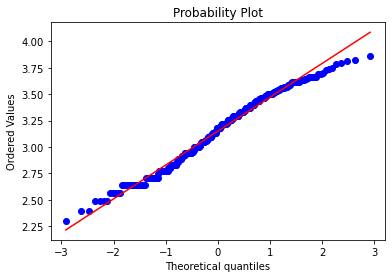

In [15]:
#Features
sns.distplot(data.target, fit = norm)

(mu, sigma) = norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

plt.figure()
stats.probplot(data["target"], plot = plt)
plt.show()

data["target"] = np.log1p(data["target"]) 

plt.figure()
sns.distplot(data.target, fit = norm)

(mu, sigma) = norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

plt.figure()
stats.probplot(data["target"], plot = plt)
plt.show()

In [16]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])

In [17]:
data["Cylinders"] = data["Cylinders"].astype(str)  
data["Origin"] = data["Origin"].astype(str) 
data = pd.get_dummies(data)

In [18]:
#Split
x = data.drop(["target"], axis = 1)
y = data.target
test_size = 0.9
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = test_size, random_state = 42)

In [19]:
# Standardization
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
#Linear regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("LR Coef: ",lr.coef_)
y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Linear Regression MSE: ",mse)

LR Coef:  [-0.05586529 -0.02878372 -0.21009667 -0.01130471  0.22985     0.
  0.03776132 -0.13263435  0.01029717  0.08457586 -0.04849905  0.08737499
 -0.03887595]
Linear Regression MSE:  0.015552240142363267


Ridge Coef:  [-0.04472386 -0.05225204 -0.17185379 -0.02372856  0.21072394  0.
  0.05817803 -0.09942096 -0.00565349  0.04689642 -0.04386739  0.07386511
 -0.02999772]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.01455149844831628
-----------------------------------------------------------


Text(0.5, 1.0, 'Ridge')

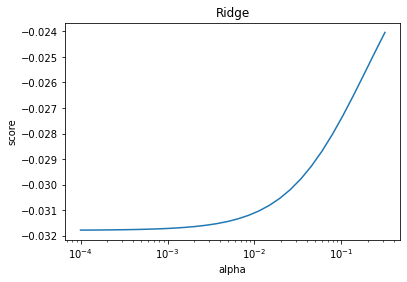

In [21]:
#Ridge regression
ridge = Ridge(random_state = 42, max_iter = 10000)
alphas = np.logspace(-4,-0.5,30)

tuned_parameters = [{'alpha':alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ",clf.best_estimator_.coef_)
ridge = clf.best_estimator_
print("Ridge Best Estimator: ", ridge)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Ridge MSE: ",mse)
print("-----------------------------------------------------------")

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")

Lasso Coef:  [-0.         -0.01220008 -0.2273529  -0.          0.19044799  0.
  0.07123682 -0.         -0.          0.         -0.02476754  0.0541475
 -0.        ]
Lasso Best Estimator:  Lasso(alpha=0.006461670787466976, max_iter=10000, random_state=42)
Lasso MSE:  0.013628383817530124
---------------------------------------------------------------


Text(0.5, 1.0, 'Lasso')

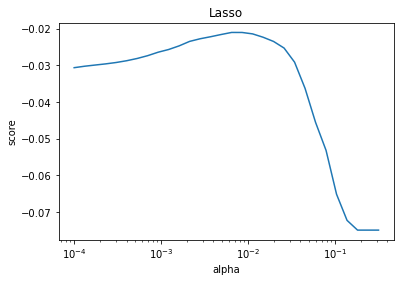

In [22]:
#Lasso regression
lasso = Lasso(random_state=42, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error',refit=True)
clf.fit(X_train,Y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print("Lasso Coef: ",clf.best_estimator_.coef_)
lasso = clf.best_estimator_
print("Lasso Best Estimator: ",lasso)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Lasso MSE: ",mse)
print("---------------------------------------------------------------")

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")

In [23]:
#ElasticNet
parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
clf.fit(X_train, Y_train)
print("ElasticNet Coef: ",clf.best_estimator_.coef_)
print("ElasticNet Best Estimator: ",clf.best_estimator_)
y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("ElasticNet MSE: ",mse)

ElasticNet Coef:  [-0.05480764 -0.07277349 -0.1098435  -0.02978964  0.15249021  0.
  0.07196083 -0.00607086 -0.01605307  0.         -0.03491925  0.03208575
  0.        ]
ElasticNet Best Estimator:  ElasticNet(alpha=0.05968456995122311, l1_ratio=0.05, max_iter=10000,
           random_state=42)
ElasticNet MSE:  0.014023527537640587


In [24]:
#xgboost
parametersGrid = {'nthread':[4],'objective':['reg:linear'],'learning_rate': [.03, 0.05, .07], 'max_depth': [5, 6, 7],
              'min_child_weight': [4],'silent': [1],'subsample': [0.7],'colsample_bytree': [0.7],'n_estimators': [500,1000]}
model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv = n_folds, scoring='neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)
clf.fit(X_train, Y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[19:05:56] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBRegressor MSE:  0.016125347442676134


In [25]:
#Averaging Models
class AveragingModels():
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)  

averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, Y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Averaged Models MSE: ",mse)

[19:06:58] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Averaged Models MSE:  0.013502546073011037
